In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
Mag_T10 = pd.read_csv("M16M3-MH10.dat",sep=' ',decimal=',')
Mag_T3 = pd.read_csv("M16M2-MH3.dat",sep=' ',decimal=',')

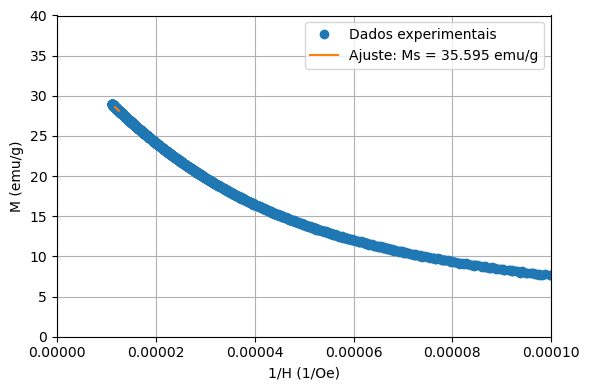

Magnetização de saturação estimada: Ms = 35.5948 emu/g
bfit: bfit = -596390.3902 emu/g


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Carrega os dados
Mag_T10 = pd.read_csv("M16M3-MH10.dat", sep=' ', decimal=',')
#Mag_T3 = pd.read_csv("M16M2-MH3.dat",sep=' ',decimal=',')

# Extrai as colunas relevantes
H = Mag_T10['MagneticField(Oe)'].values
M = Mag_T10['M(emu/g)'].values

# Define a função de ajuste: M(H) = Ms + b/H
def linear_invH(H, Ms, b):
    return Ms + b / H

# Define os limites inferior (a) e superior (b) do campo magnético
a = 80000   # menor campo em Oe
b = 85000  # maior campo em Oe

# Aplica a máscara
mask = (H >= a) & (H <= b)
H_sel = H[mask]
M_sel = M[mask]

# Verificação de segurança
if len(H_sel) < 2:
    raise ValueError("Poucos ou nenhum ponto selecionado. Ajuste os valores de a e b.")

# Ajuste de curva
params, _ = curve_fit(linear_invH, H_sel, M_sel)
Ms, b_fit = params

# Curva ajustada para visualização
H_fit = np.linspace(a, b, 300)
M_fit = linear_invH(H_fit, Ms, b_fit)

# Plotagem
plt.figure(figsize=(6,4))
plt.plot(1/H, M, 'o', label='Dados experimentais')
plt.plot(1/H_fit, M_fit, '-', label=f'Ajuste: Ms = {Ms:.3f} emu/g')

#plt.xlim(1/b, 1/a)  # mesmo intervalo usado na máscara, mas em 1/H
plt.xlim(0,0.0001)
plt.ylim(0,40)
plt.xlabel('1/H (1/Oe)')
plt.ylabel('M (emu/g)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Exibe o valor estimado
print(f"Magnetização de saturação estimada: Ms = {Ms:.4f} emu/g")
print(f"bfit: bfit = {b_fit:.4f} emu/g")


In [21]:
b_fit

-537021.5085429666

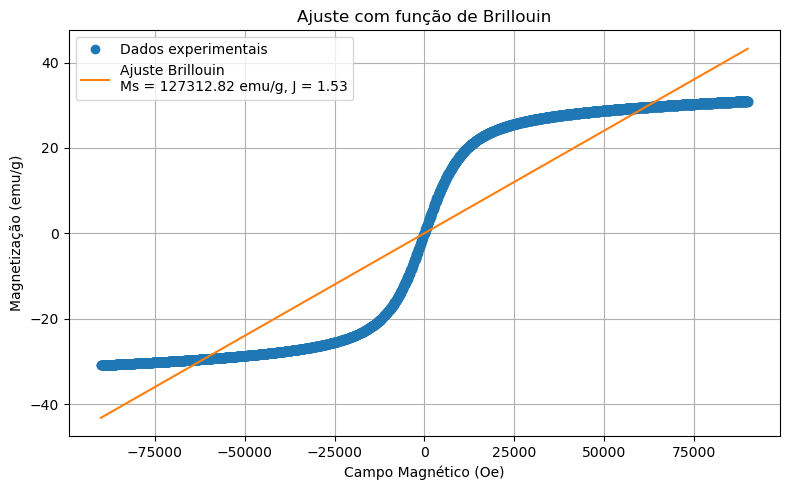

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define coth
np.coth = lambda x: 1 / np.tanh(x)

# Função de Brillouin
def brillouin(J, x):
    term1 = (2*J + 1)/(2*J) * np.coth((2*J + 1)*x / (2*J))
    term2 = 1/(2*J) * np.coth(x / (2*J))
    return term1 - term2

# Modelo de magnetização
def magnetizacao_model(H_Oe, M_s, J, T):
    H_T = H_Oe * 1e-4  # converte de Oe para T
    mu_B = 9.274e-21   # emu·T/g (convertido para unidades compatíveis com emu/g)
    k_B = 1.381e-16    # erg/K
    g = 2
    x = (g * mu_B * J * H_T) / (k_B * T)
    return M_s * brillouin(J, x)

# Função de ajuste
def ajustar_brillouin(H_Oe, M_exp, T):
    p0 = [max(M_exp), 3/2]  # chute inicial para Ms e J
    bounds = ([0, 0.1], [np.inf, 10])  # limitações físicas
    popt, pcov = curve_fit(lambda H, Ms, J: magnetizacao_model(H, Ms, J, T),
                           H_Oe, M_exp, p0=p0, bounds=bounds)
    M_s, J = popt
    return M_s, J, popt, pcov

# Dados experimentais
H = Mag_T3['MagneticField(Oe)'].values
M = Mag_T3['M(emu/g)'].values
T = 3  # temperatura em K

# Ajuste
M_s, J, popt, pcov = ajustar_brillouin(H, M, T)

# Plot do resultado
H_fit = np.linspace(min(H), max(H), 500)
M_fit = magnetizacao_model(H_fit, *popt, T)

plt.figure(figsize=(8,5))
plt.plot(H, M, 'o', label='Dados experimentais')
plt.plot(H_fit, M_fit, '-', label=f'Ajuste Brillouin\nMs = {M_s:.2f} emu/g, J = {J:.2f}')
plt.xlabel('Campo Magnético (Oe)')
plt.ylabel('Magnetização (emu/g)')
plt.title('Ajuste com função de Brillouin')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
